# Plots of the yield models used in R68 analysis

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

exec(open("nb_setup.py").read())
import R68_yield as Yield

../mplstyles
3.1.1
/data/chocula/mast/cdms/analysis/run068/R68_paper2019/mplstyles
dict_keys(['xx', 'yy', 'ex', 'ey'])


We consider here 3 different yield model paramterizations. The first is Lindhard (http://gymarkiv.sdu.dk/MFM/kdvs/mfm%2030-39/mfm-33-10.pdf).
\begin{equation}
y_L(E_r,k) = \frac{kg}{1+kg}
\end{equation}
where $g = 3 \varepsilon^{0.15} + 0.7\varepsilon^{0.6} + \varepsilon$ and $\varepsilon = 11.5 E_r [keV] Z^{-7/3}$ and here, Z=14 (Si).

Then two modifications from Chavarria (https://arxiv.org/pdf/1803.02903.pdf) and Sorensen(https://journals.aps.org/prd/pdf/10.1103/PhysRevD.91.083509) which both change the low-energy cutoff behavior. Chavarria is simply empirical while Sorensen is motivated by a low-energy ionization threshold such as in semiconductors.


\begin{equation}
y_C(E_r,k,a) = \left(\frac{1}{a E_r}+\frac{1}{y_L(E_r,k)}\right)^{-1}
\end{equation}

and 

\begin{equation}
y_S(E_r,k,q) = y_L(E_r,k)-\frac{q}{\varepsilon}
\end{equation}

In [9]:
E_thresh=50 #[eV] Possible analysis threshold
E_test=np.logspace(-1,4,1000)

fig_w=7

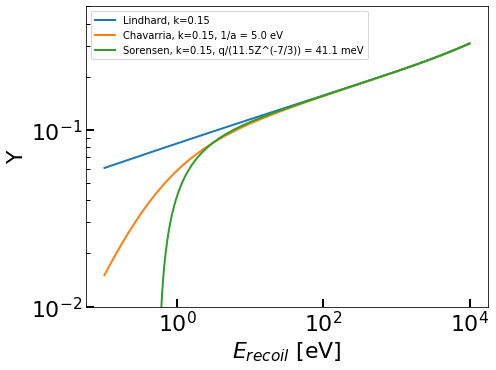

In [14]:
fig,ax = plt.subplots(1,1,figsize=(fig_w, fig_w*(.75)))

#Y=Yield.Yield('Damic',[])
#plt.plot(E_test,Y.calc(E_test),label='Damic')

Y=Yield.Yield('Lind',[0.15])
plt.plot(E_test,Y.calc(E_test),label='Lindhard, k=0.15')

Y=Yield.Yield('Chav',[0.15,0.2])
ainv=1./0.2 #[eV]
plt.plot(E_test,Y.calc(E_test),label='Chavarria, k=0.15, 1/a = {0:.1f} eV'.format(round(ainv)))

qeff_meV=1e-6/11.5e-3/14**(-7./3)*1e3
Y=Yield.Yield('Sor',[0.15,1e-6])
plt.plot(E_test,Y.calc(E_test),label='Sorensen, k=0.15, q/(11.5Z^(-7/3)) = {0:.1f} meV'.format(qeff_meV))

plt.gca().set_xlabel(r'$E_{recoil}$ [eV]')
plt.gca().set_ylabel('Y')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_ylim(1e-2,0.5)
#plt.gca().set_ylim(0,0.3)

plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig('figures/yield_models.png')